In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [3]:
columns = ['gene_id', 'm1', 'm2','m3','m4','m5']
TET2 = pd.read_csv('/work/iku/exp1019-cancer-epigenetics-and-ervs/01_BS_and_ERV/results/04_TEtranscripts/TET2/TET2.cntTable', sep = '\t' , names=columns, header = 1)

In [4]:
print(TET2)

                         gene_id   m1   m2   m3   m4   m5
0             ENSMUSG00000000003    0    0    0    0    0
1             ENSMUSG00000000028  883  400  370  232  172
2             ENSMUSG00000000031    0    0    0    0    0
3             ENSMUSG00000000037    0    0    0    0    0
4             ENSMUSG00000000049    0    0    0    0    0
...                          ...  ...  ...  ...  ...  ...
49769     Zaphod2:hAT-Tip100:DNA  101  132   71   91   98
49770     Zaphod3:hAT-Tip100:DNA   44   16    9  104   63
49771      Zaphod:hAT-Tip100:DNA    9    7    3   14   25
49772         hAT-N1_Mam:hAT:DNA   27   19   11   22   24
49773  nhAT5a_ML:hAT-Charlie:DNA    0    0    0    0    0

[49774 rows x 6 columns]


In [6]:
#ERV_info = pd.read_csv('exp1019-cancer-epigenetics-and-ervs/notebooks/ENMUS_to_gene_id.tsv', sep = '\t')

In [9]:
TET2_ERV = TET2[TET2['gene_id'].str.startswith('Mmus')]

In [10]:
print(TET2_ERV.info())

<class 'pandas.core.frame.DataFrame'>
Index: 601 entries, 48027 to 48627
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   gene_id  601 non-null    object
 1   m1       601 non-null    int64 
 2   m2       601 non-null    int64 
 3   m3       601 non-null    int64 
 4   m4       601 non-null    int64 
 5   m5       601 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 32.9+ KB
None


In [20]:
def filter_non_expressed_ERV(df):
    df = df.copy()
    count_columns = [col for col in df.columns if col.startswith('m')]

    # Sum values along the rows for selected columns
    df.loc[:, 'sum_counts'] = df[count_columns].astype(int).sum(axis=1)
    
    # Filter rows where sum_counts is greater than 0
    df = df.loc[df['sum_counts'] > 0]
    
    # Reset index starting from 0
    df.reset_index(drop=True, inplace=True)
    
    # Drop the temporary 'sum_counts' column
    del df['sum_counts']
    
    return df


In [21]:
expr_ERV = filter_non_expressed_ERV(TET2_ERV)

In [13]:
print(expr_ERV)

                              gene_id   m1   m2   m3   m4   m5
0   Mmus38.chr1.100281908.100282162.-    0    0    1    0    0
1     Mmus38.chr1.10322384.10323019.+  109   99   25   14   64
2   Mmus38.chr1.131672160.131672417.+    1    2    0    0    2
3     Mmus38.chr1.97792275.97792568.+    5    4    6    4    4
4    Mmus38.chr10.51538884.51539135.-    0    0    1    0    0
5      Mmus38.chr10.7468158.7468415.+    0    3    1    0    0
6    Mmus38.chr11.22789091.22789513.+    0    1    0    1    0
7    Mmus38.chr12.99645621.99645989.+  132   13   61   68   10
8    Mmus38.chr17.34998853.34999251.-  215   57   95  104  101
9   Mmus38.chr4.145830292.145830672.-    7    0   10   14    4
10  Mmus38.chr4.146468607.146468987.-    3    3   10    2    1
11  Mmus38.chr4.147180929.147181309.-    4    7    4   16    8
12    Mmus38.chr6.86628075.86629190.+  352  353  118  127  113
13    Mmus38.chr6.87845121.87845363.-  218   80  107  111   72
14  Mmus38.chr7.142380732.142380977.-  285  153  200  1

In [22]:
def reshape_dataframe(df):
    id_vars = ['gene_id']
    value_vars = [col for col in df.columns if col.startswith('m')]
    
    # Melt the DataFrame
    melted_df = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='patient_id', value_name='count')
    
    # Extract patient_id from column names
    #melted_df['patient_id'] = melted_df['patient_id'].str.split('_', expand=True)[1].astype(int)
    
    return melted_df

In [23]:
reshaped = reshape_dataframe(expr_ERV)
print(reshaped.head())

                             gene_id patient_id  count
0  Mmus38.chr1.100281908.100282162.-         m1      0
1    Mmus38.chr1.10322384.10323019.+         m1    109
2  Mmus38.chr1.131672160.131672417.+         m1      1
3    Mmus38.chr1.97792275.97792568.+         m1      5
4   Mmus38.chr10.51538884.51539135.-         m1      0


In [24]:
def visualise_ERV_expression(df, plot_type, threshold = False):
    plt.figure(figsize=(30, 30)) 

    if plot_type == 'scatter':
        sns.scatterplot(data=df, x='gene_id', y='count', hue='patient_id', palette = 'tab10') #s=4
    if plot_type == 'line':
        sns.lineplot(data=df, x='gene_id', y='count', hue='patient_id', palette = 'tab10')
    
    plt.xlabel('ERV id')
    plt.ylabel('count')

    plt.title('ERV expression levels measured with TEtranscripts')

    # Adding legend
    plt.legend(title='Mouse ID', loc='upper right')
    if threshold == True:
        plt.xticks(rotation=90)

    plt.show()    

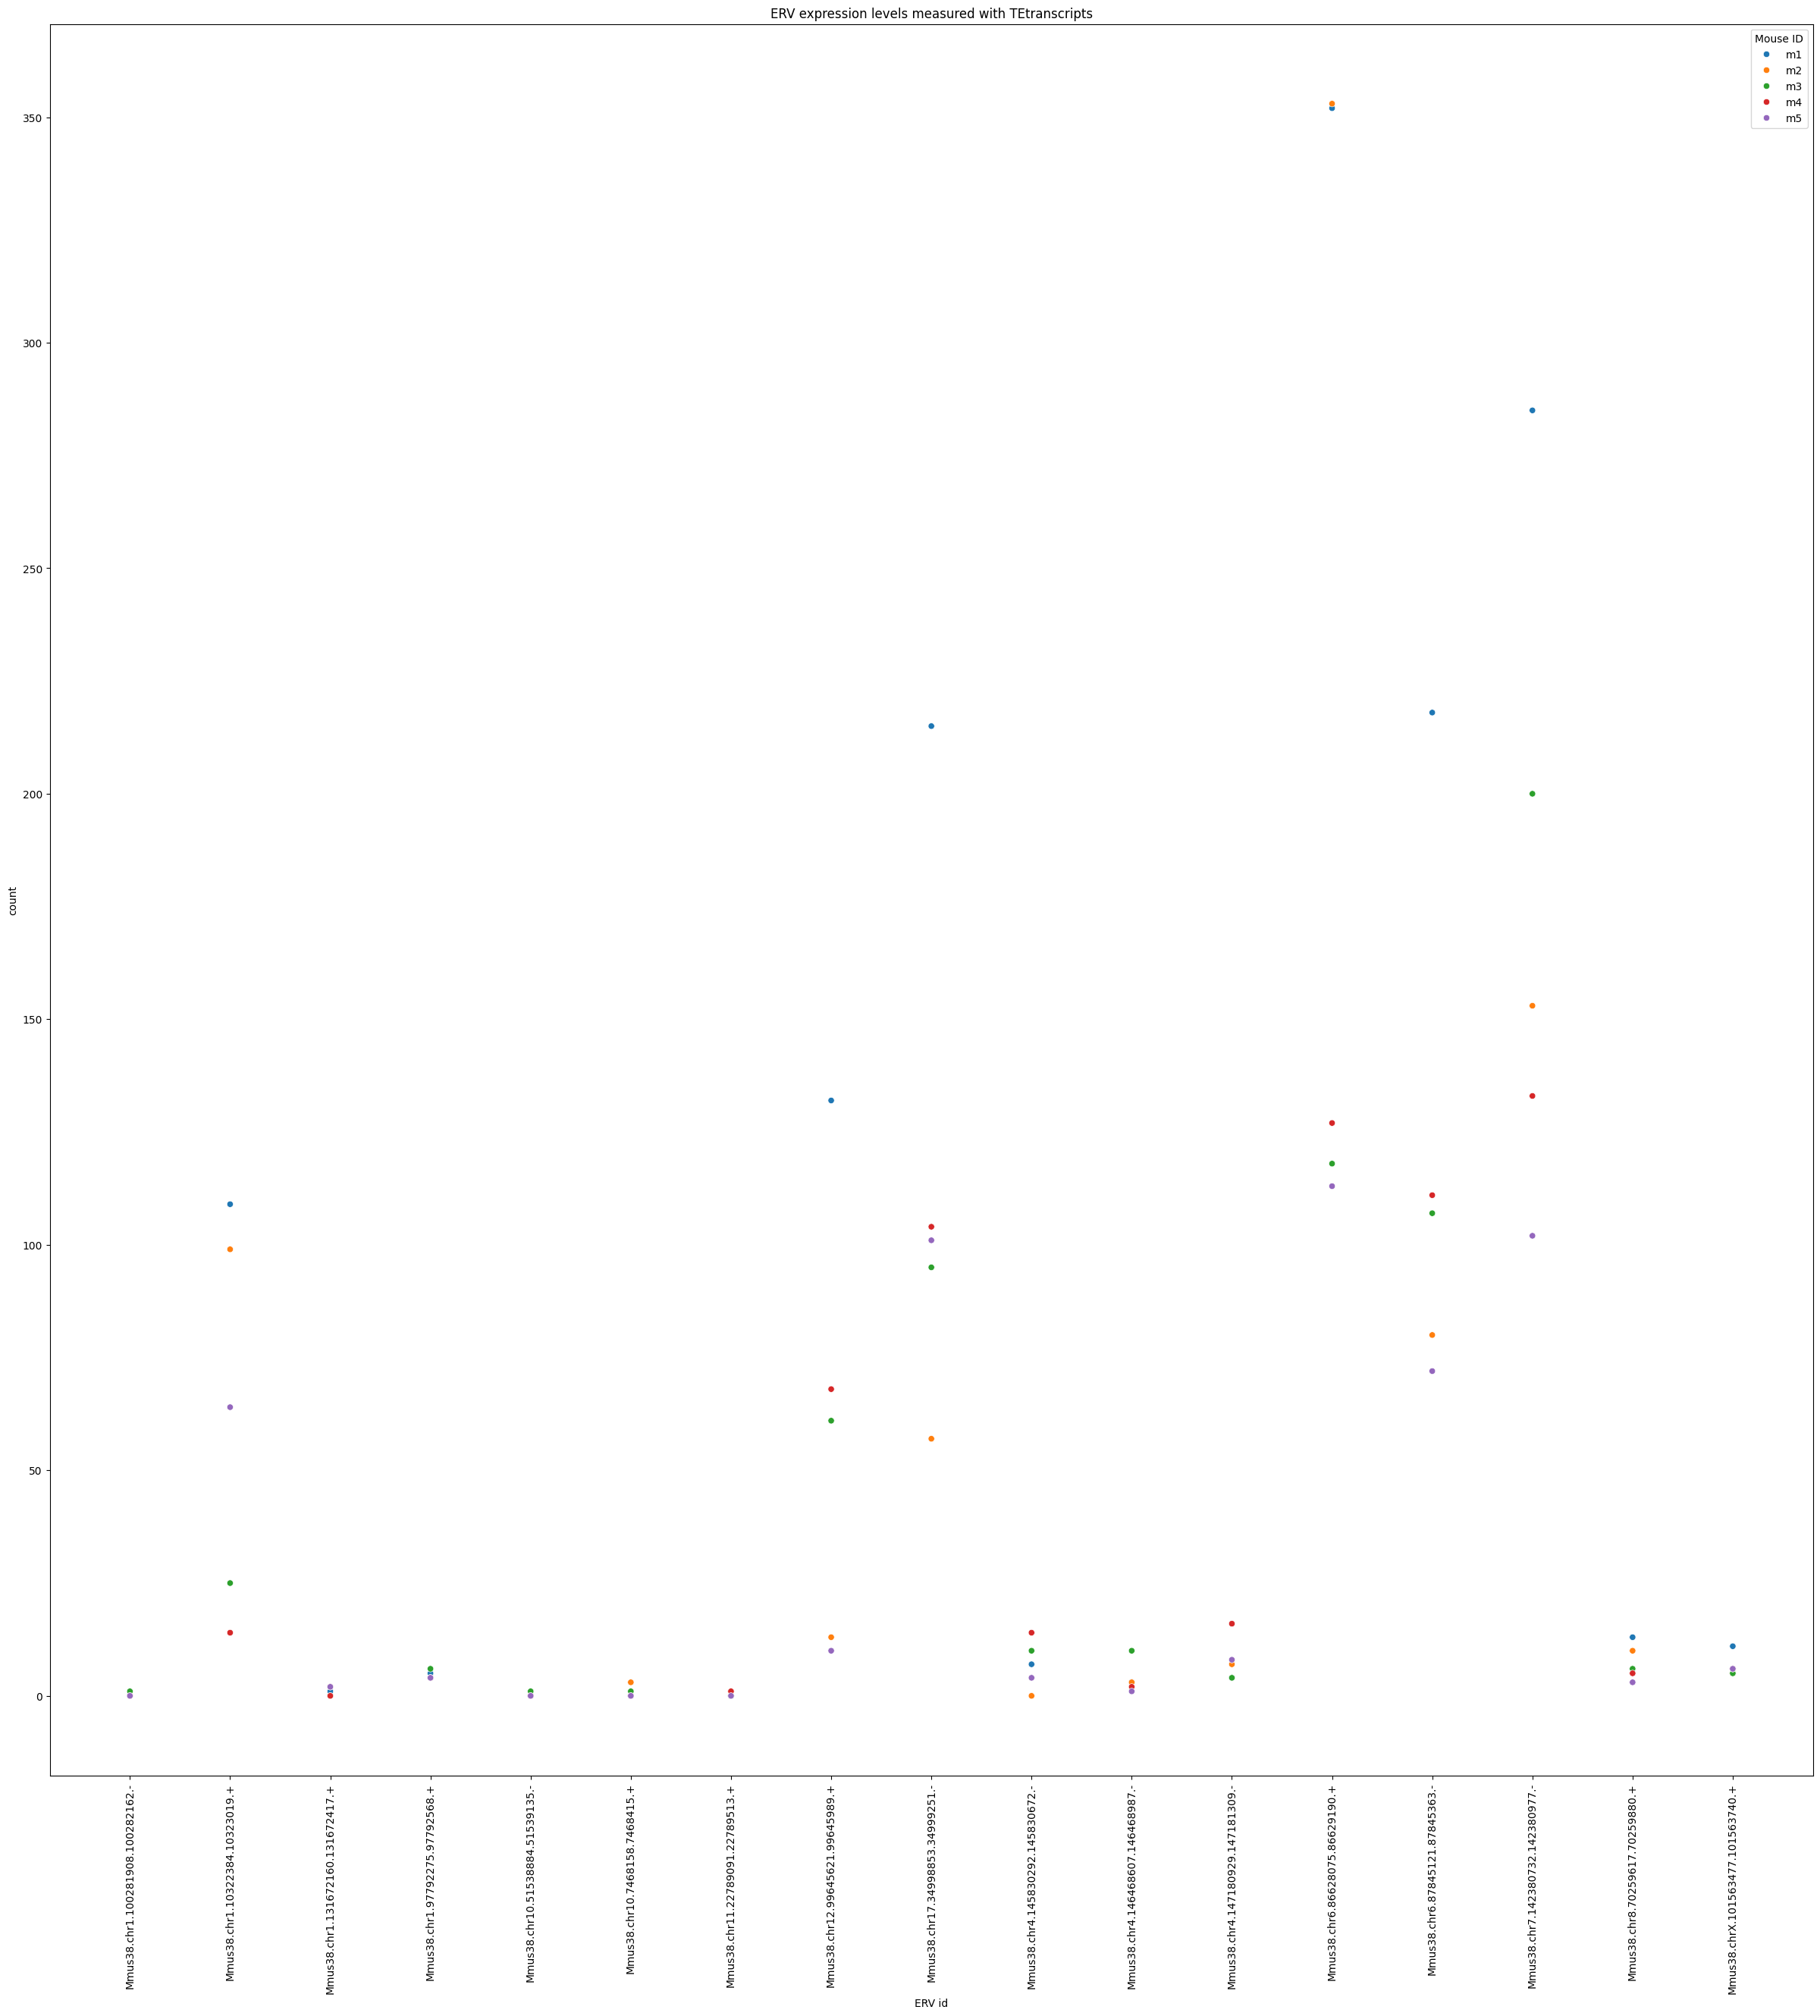

In [28]:
visualise_ERV_expression(reshaped, 'scatter', threshold = True)

In [26]:
def visualise_ERV_expression_gropus(df, plot_type, threshold = False):
    plt.figure(figsize=(30, 30)) 

    palette = {'m1': 'red', 'm2': 'red', 'm3': 'blue', 'm4': 'blue', 'm5': 'blue'}

    if plot_type == 'scatter':
        sns.scatterplot(data=df, x='gene_id', y='count', hue='patient_id', palette = palette) #s=4
    if plot_type == 'line':
        sns.lineplot(data=df, x='gene_id', y='count', hue='patient_id', palette = palette)
    
    plt.xlabel('ERV id')
    plt.ylabel('count')

    plt.title('ERV expression levels measured with TEtranscripts')

    # Adding legend
    plt.legend(title='Mouse ID', loc='upper right')

    if threshold == True:
        plt.xticks(rotation=90)

    plt.show()    

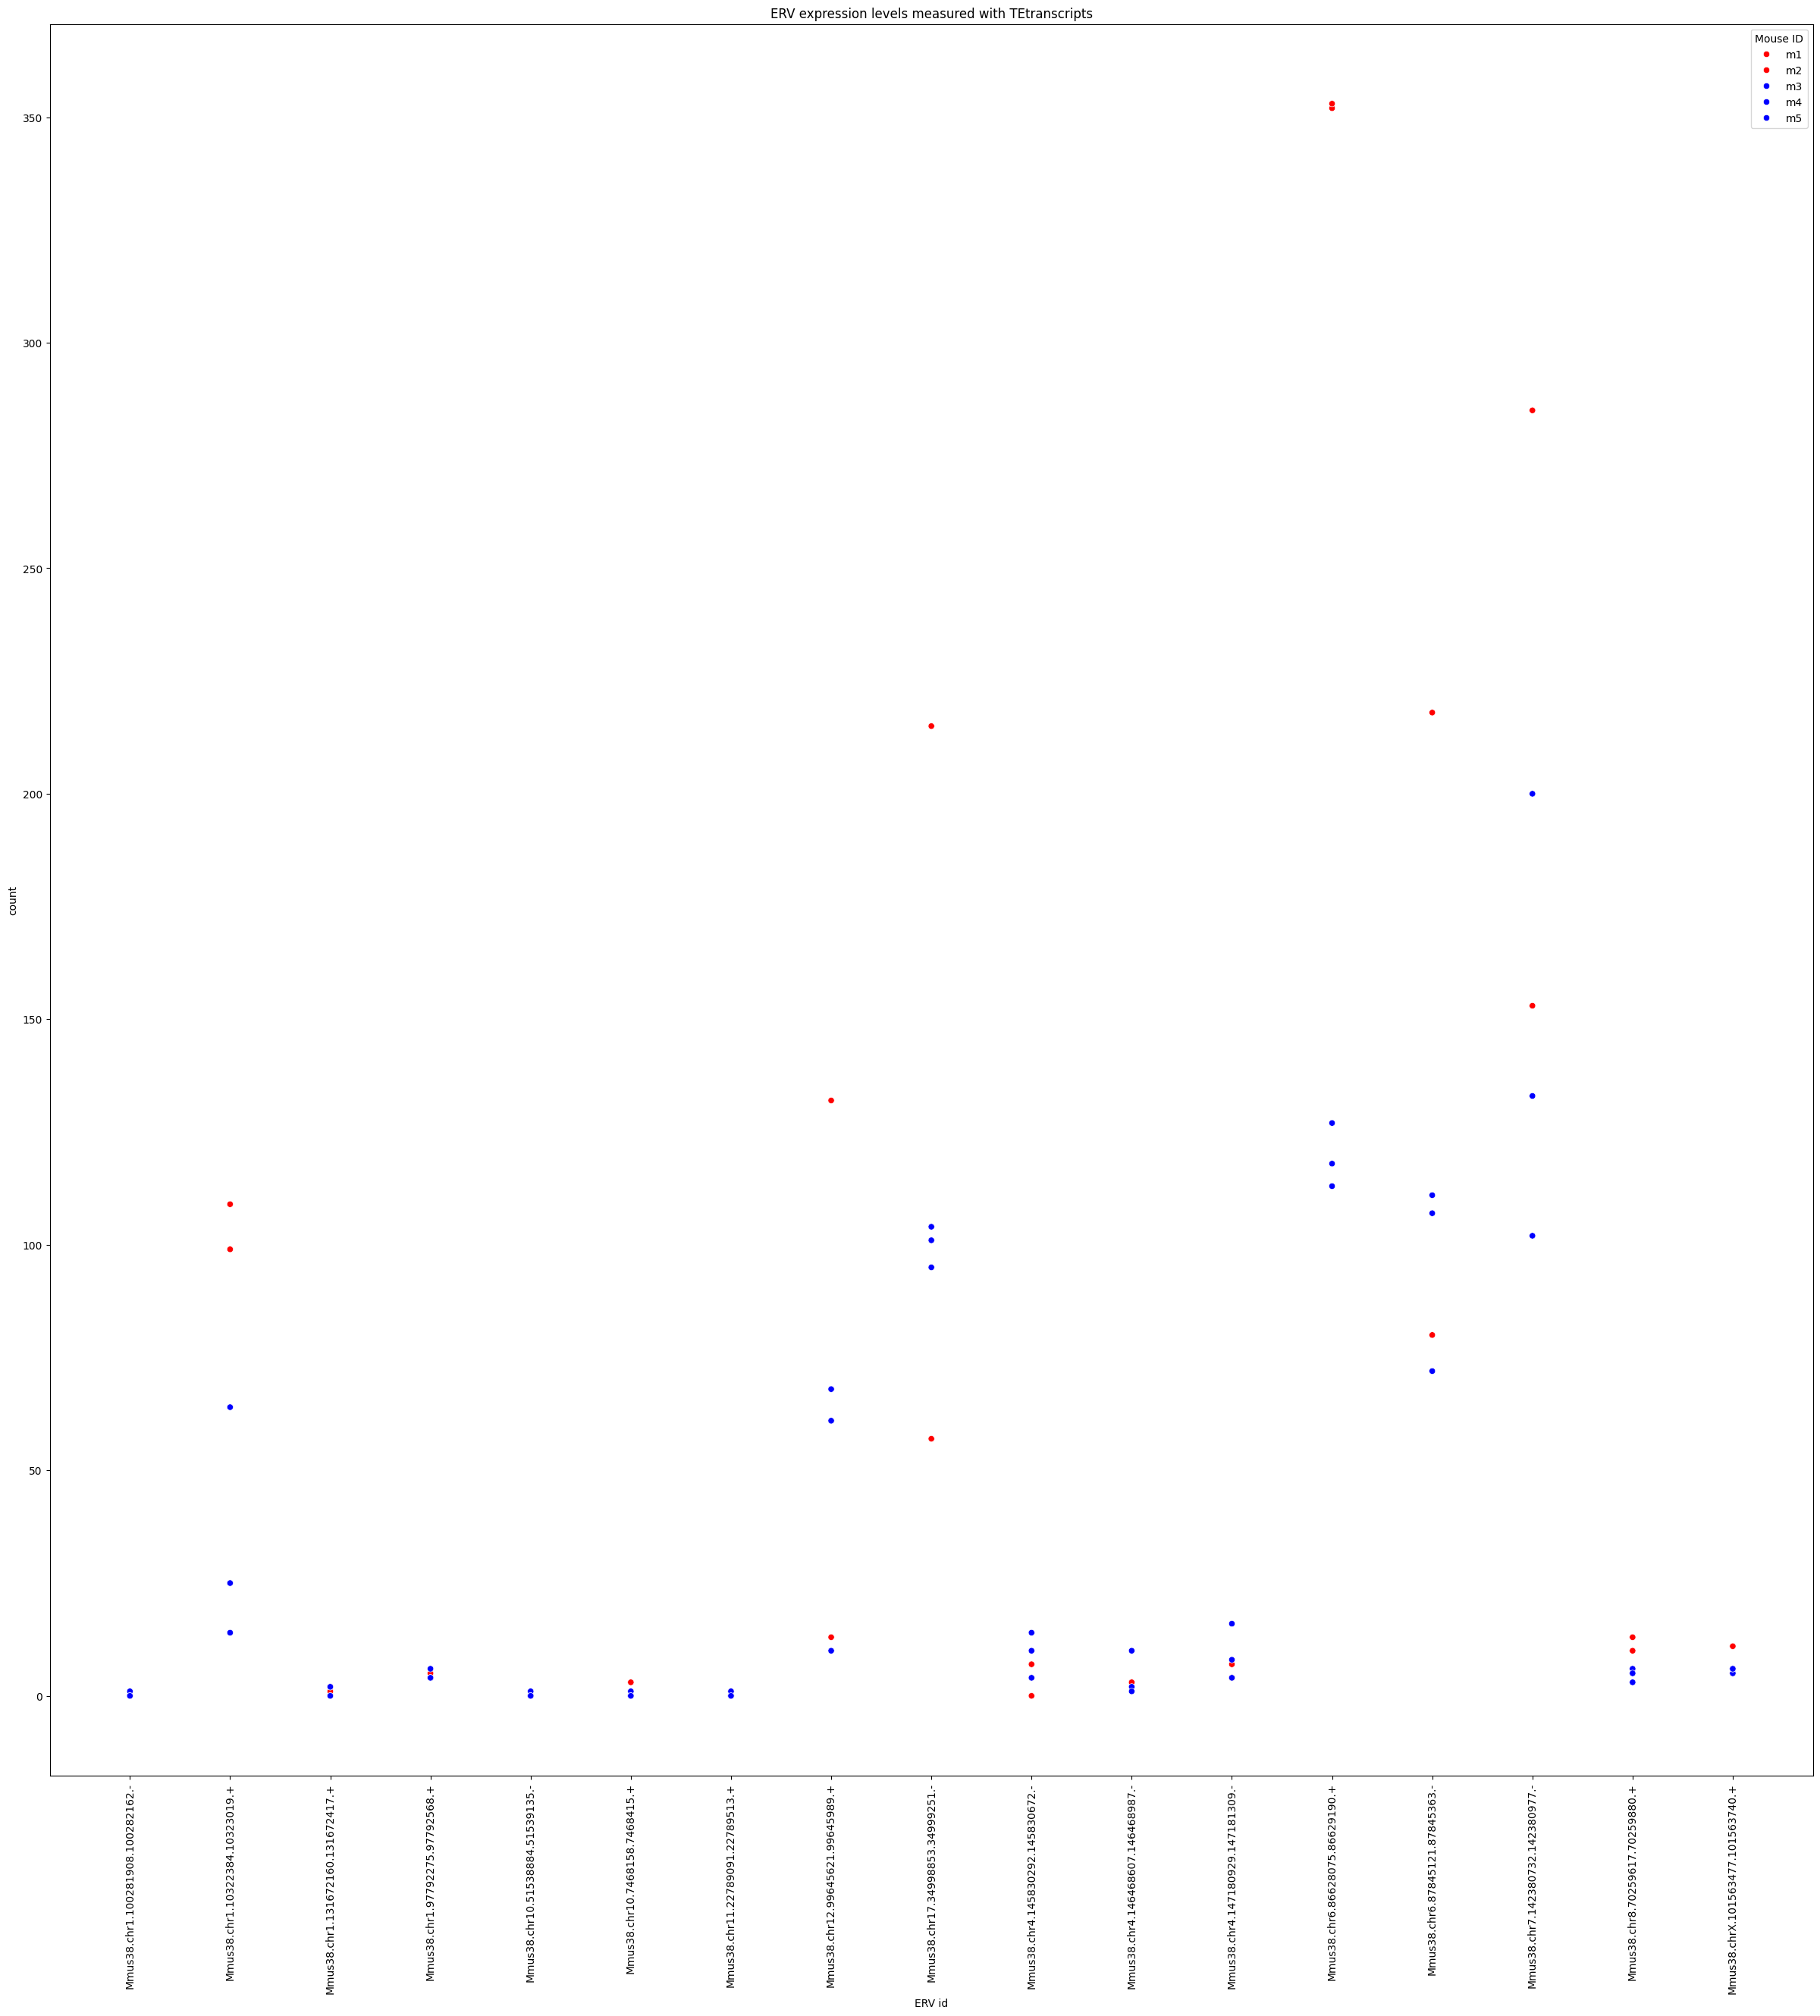

In [31]:
visualise_ERV_expression_gropus(reshaped, 'scatter', threshold = True)

In [36]:
def remove_lowly_expressed(df, threshold):
    counts_cols = [col for col in df.columns if col.startswith('m')]
    mask = (df[counts_cols] >= threshold).any(axis=1) & (df[counts_cols] <= 500).all(axis=1)
    filtered_df = df[mask]
    filtered_df.reset_index(drop=True, inplace=True)
    return filtered_df


In [37]:
filtered = remove_lowly_expressed(expr_ERV, 20)
print(filtered.head())

reshaped_filtered = reshape_dataframe(filtered)
print(reshaped_filtered.head())

                            gene_id   m1   m2   m3   m4   m5
0   Mmus38.chr1.10322384.10323019.+  109   99   25   14   64
1  Mmus38.chr12.99645621.99645989.+  132   13   61   68   10
2  Mmus38.chr17.34998853.34999251.-  215   57   95  104  101
3   Mmus38.chr6.86628075.86629190.+  352  353  118  127  113
4   Mmus38.chr6.87845121.87845363.-  218   80  107  111   72
                            gene_id patient_id  count
0   Mmus38.chr1.10322384.10323019.+         m1    109
1  Mmus38.chr12.99645621.99645989.+         m1    132
2  Mmus38.chr17.34998853.34999251.-         m1    215
3   Mmus38.chr6.86628075.86629190.+         m1    352
4   Mmus38.chr6.87845121.87845363.-         m1    218


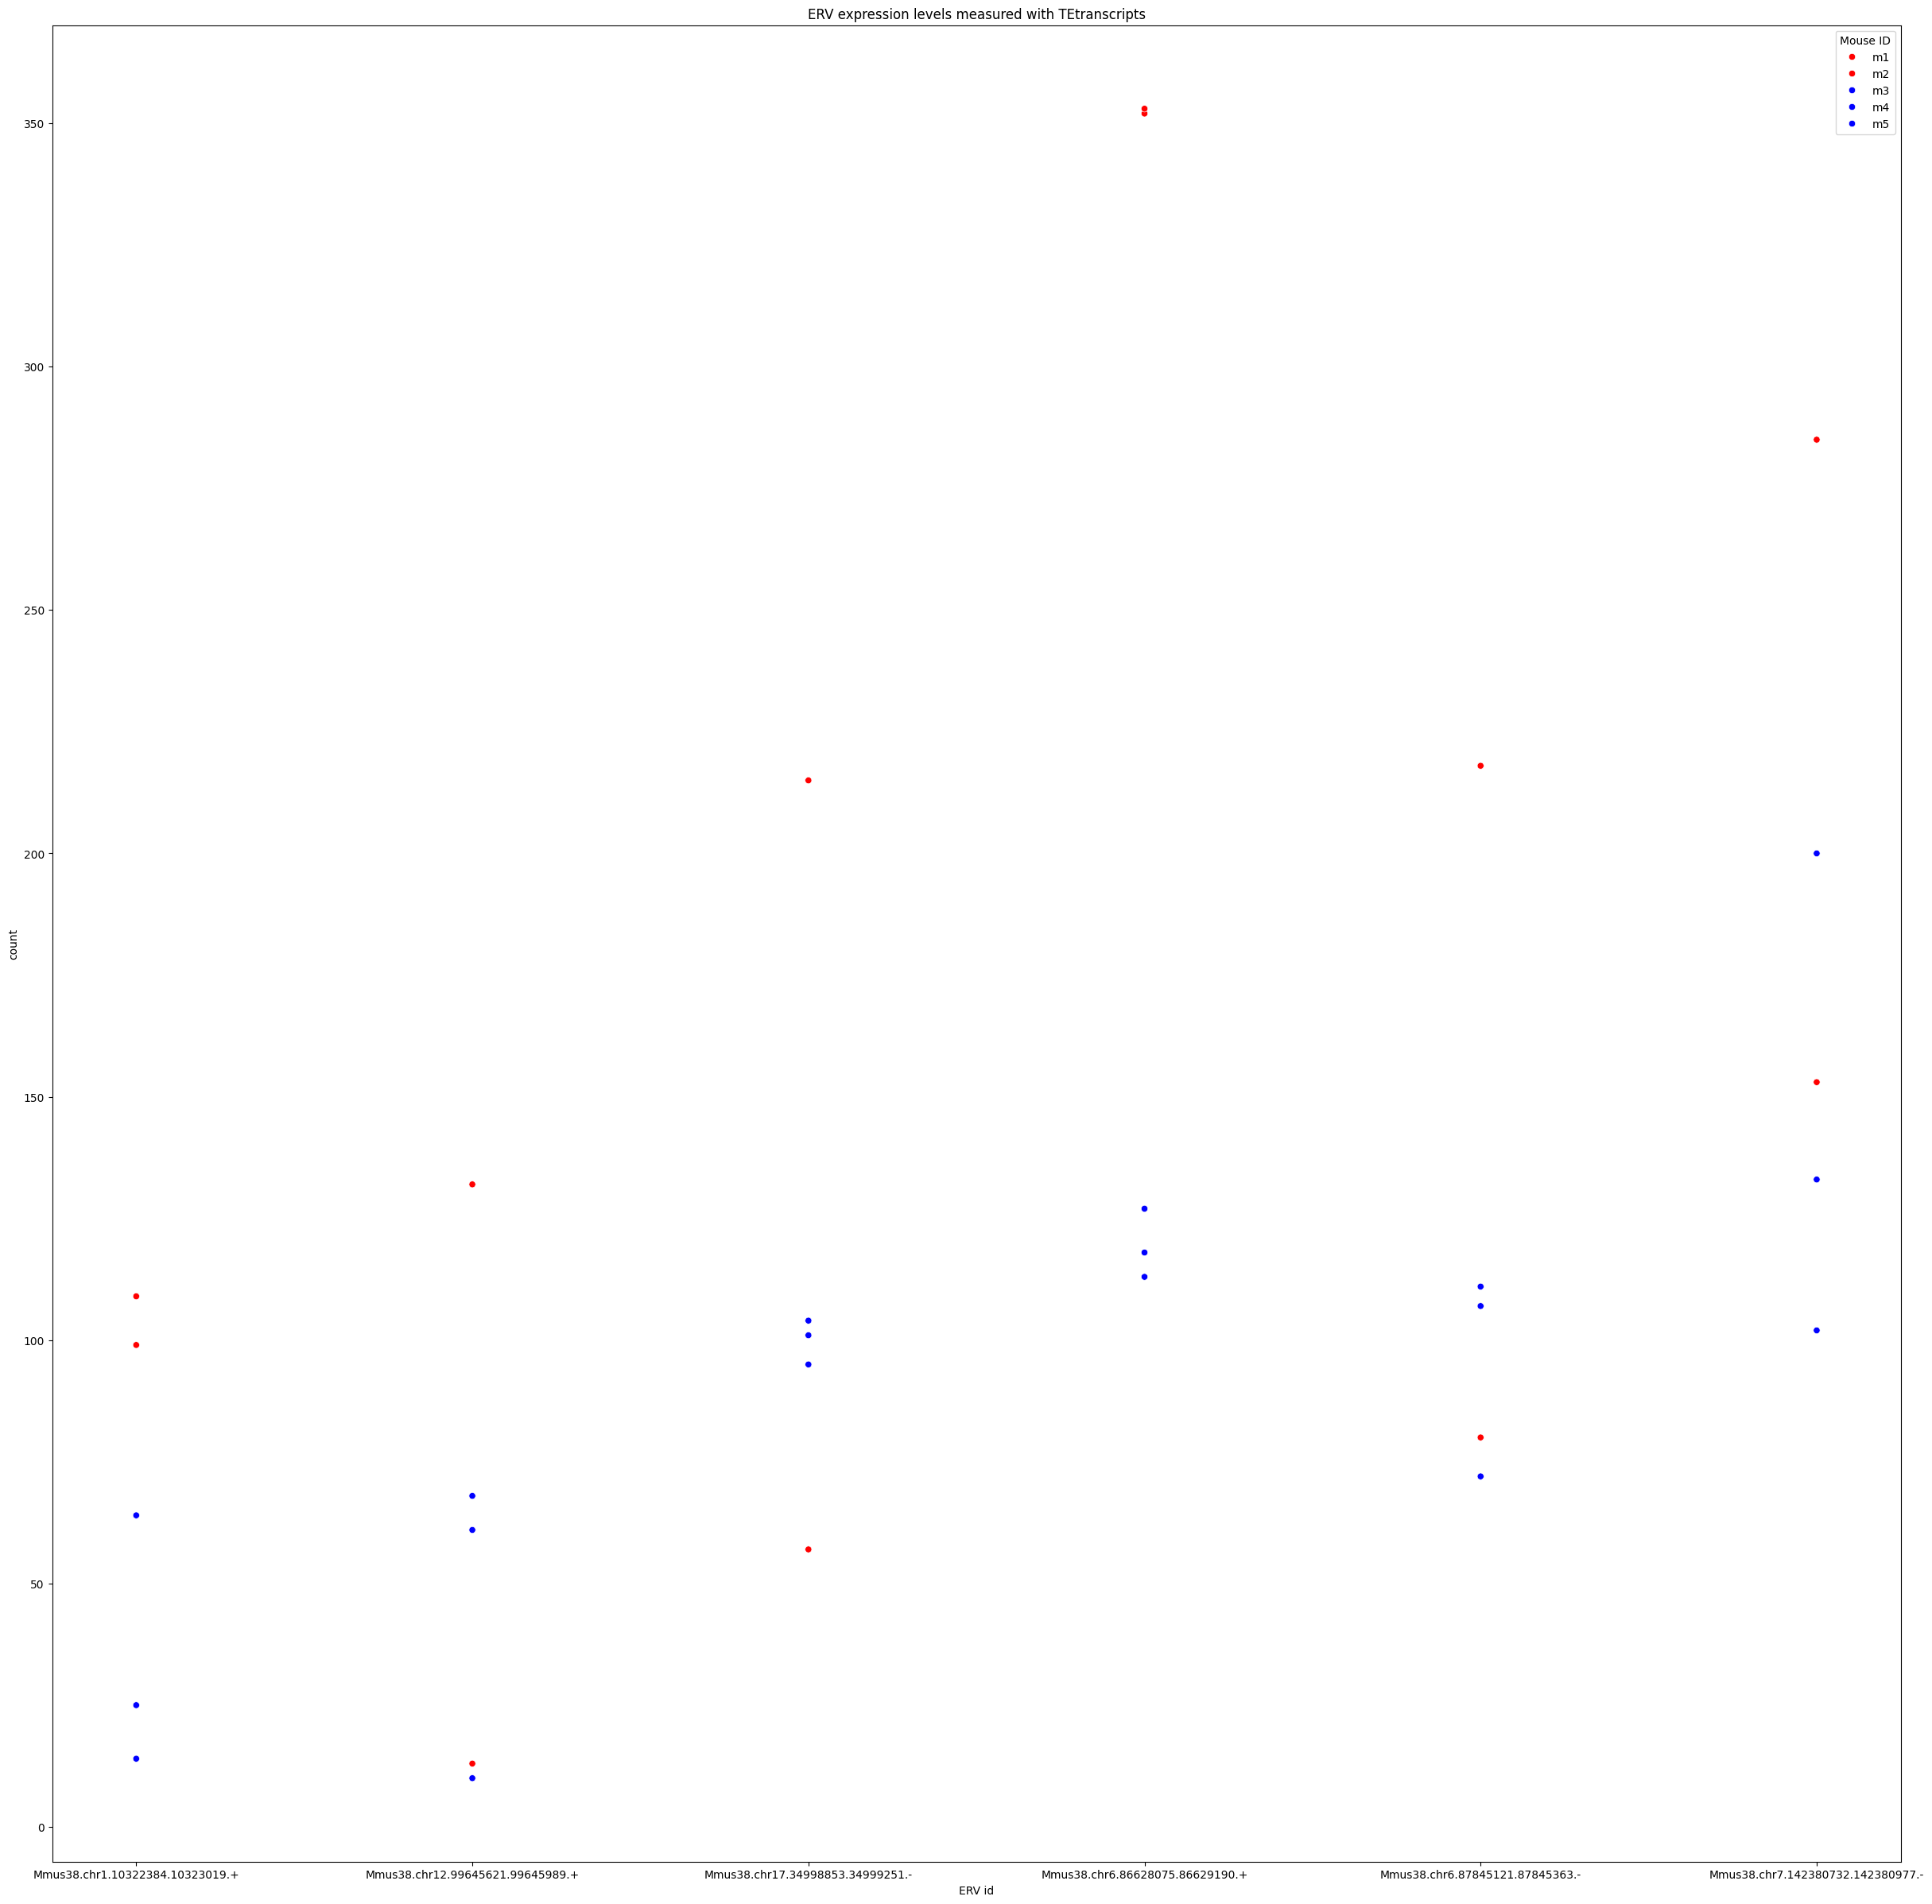

In [38]:
visualise_ERV_expression_gropus(reshaped_filtered, 'scatter')


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualise_barplot(df,plot_name, threshold=False):
    plt.figure(figsize=(30, 30)) 
    palette = {'m1': 'red', 'm2': 'red', 'm3': 'blue', 'm4': 'blue', 'm5': 'blue'}
    
    sns.barplot(data=df, x='gene_id', y='count', hue='patient_id', palette=palette) #s=4
    
    plt.xlabel('ERV id')
    plt.ylabel('count')

    plt.title('ERV expression levels measured with TEtranscripts')

    # Adding legend
    plt.legend(title='Mouse ID', loc='upper right')
    if threshold:
        plt.xticks(rotation=90)
    
    # Save plot under the DataFrame name
    plt.savefig(plot_name)
    plt.show()

# Example usage:
# Assuming df has been defined and named as follows
# df.name = 'my_dataframe'
# visualise_barplot(df, threshold=True)


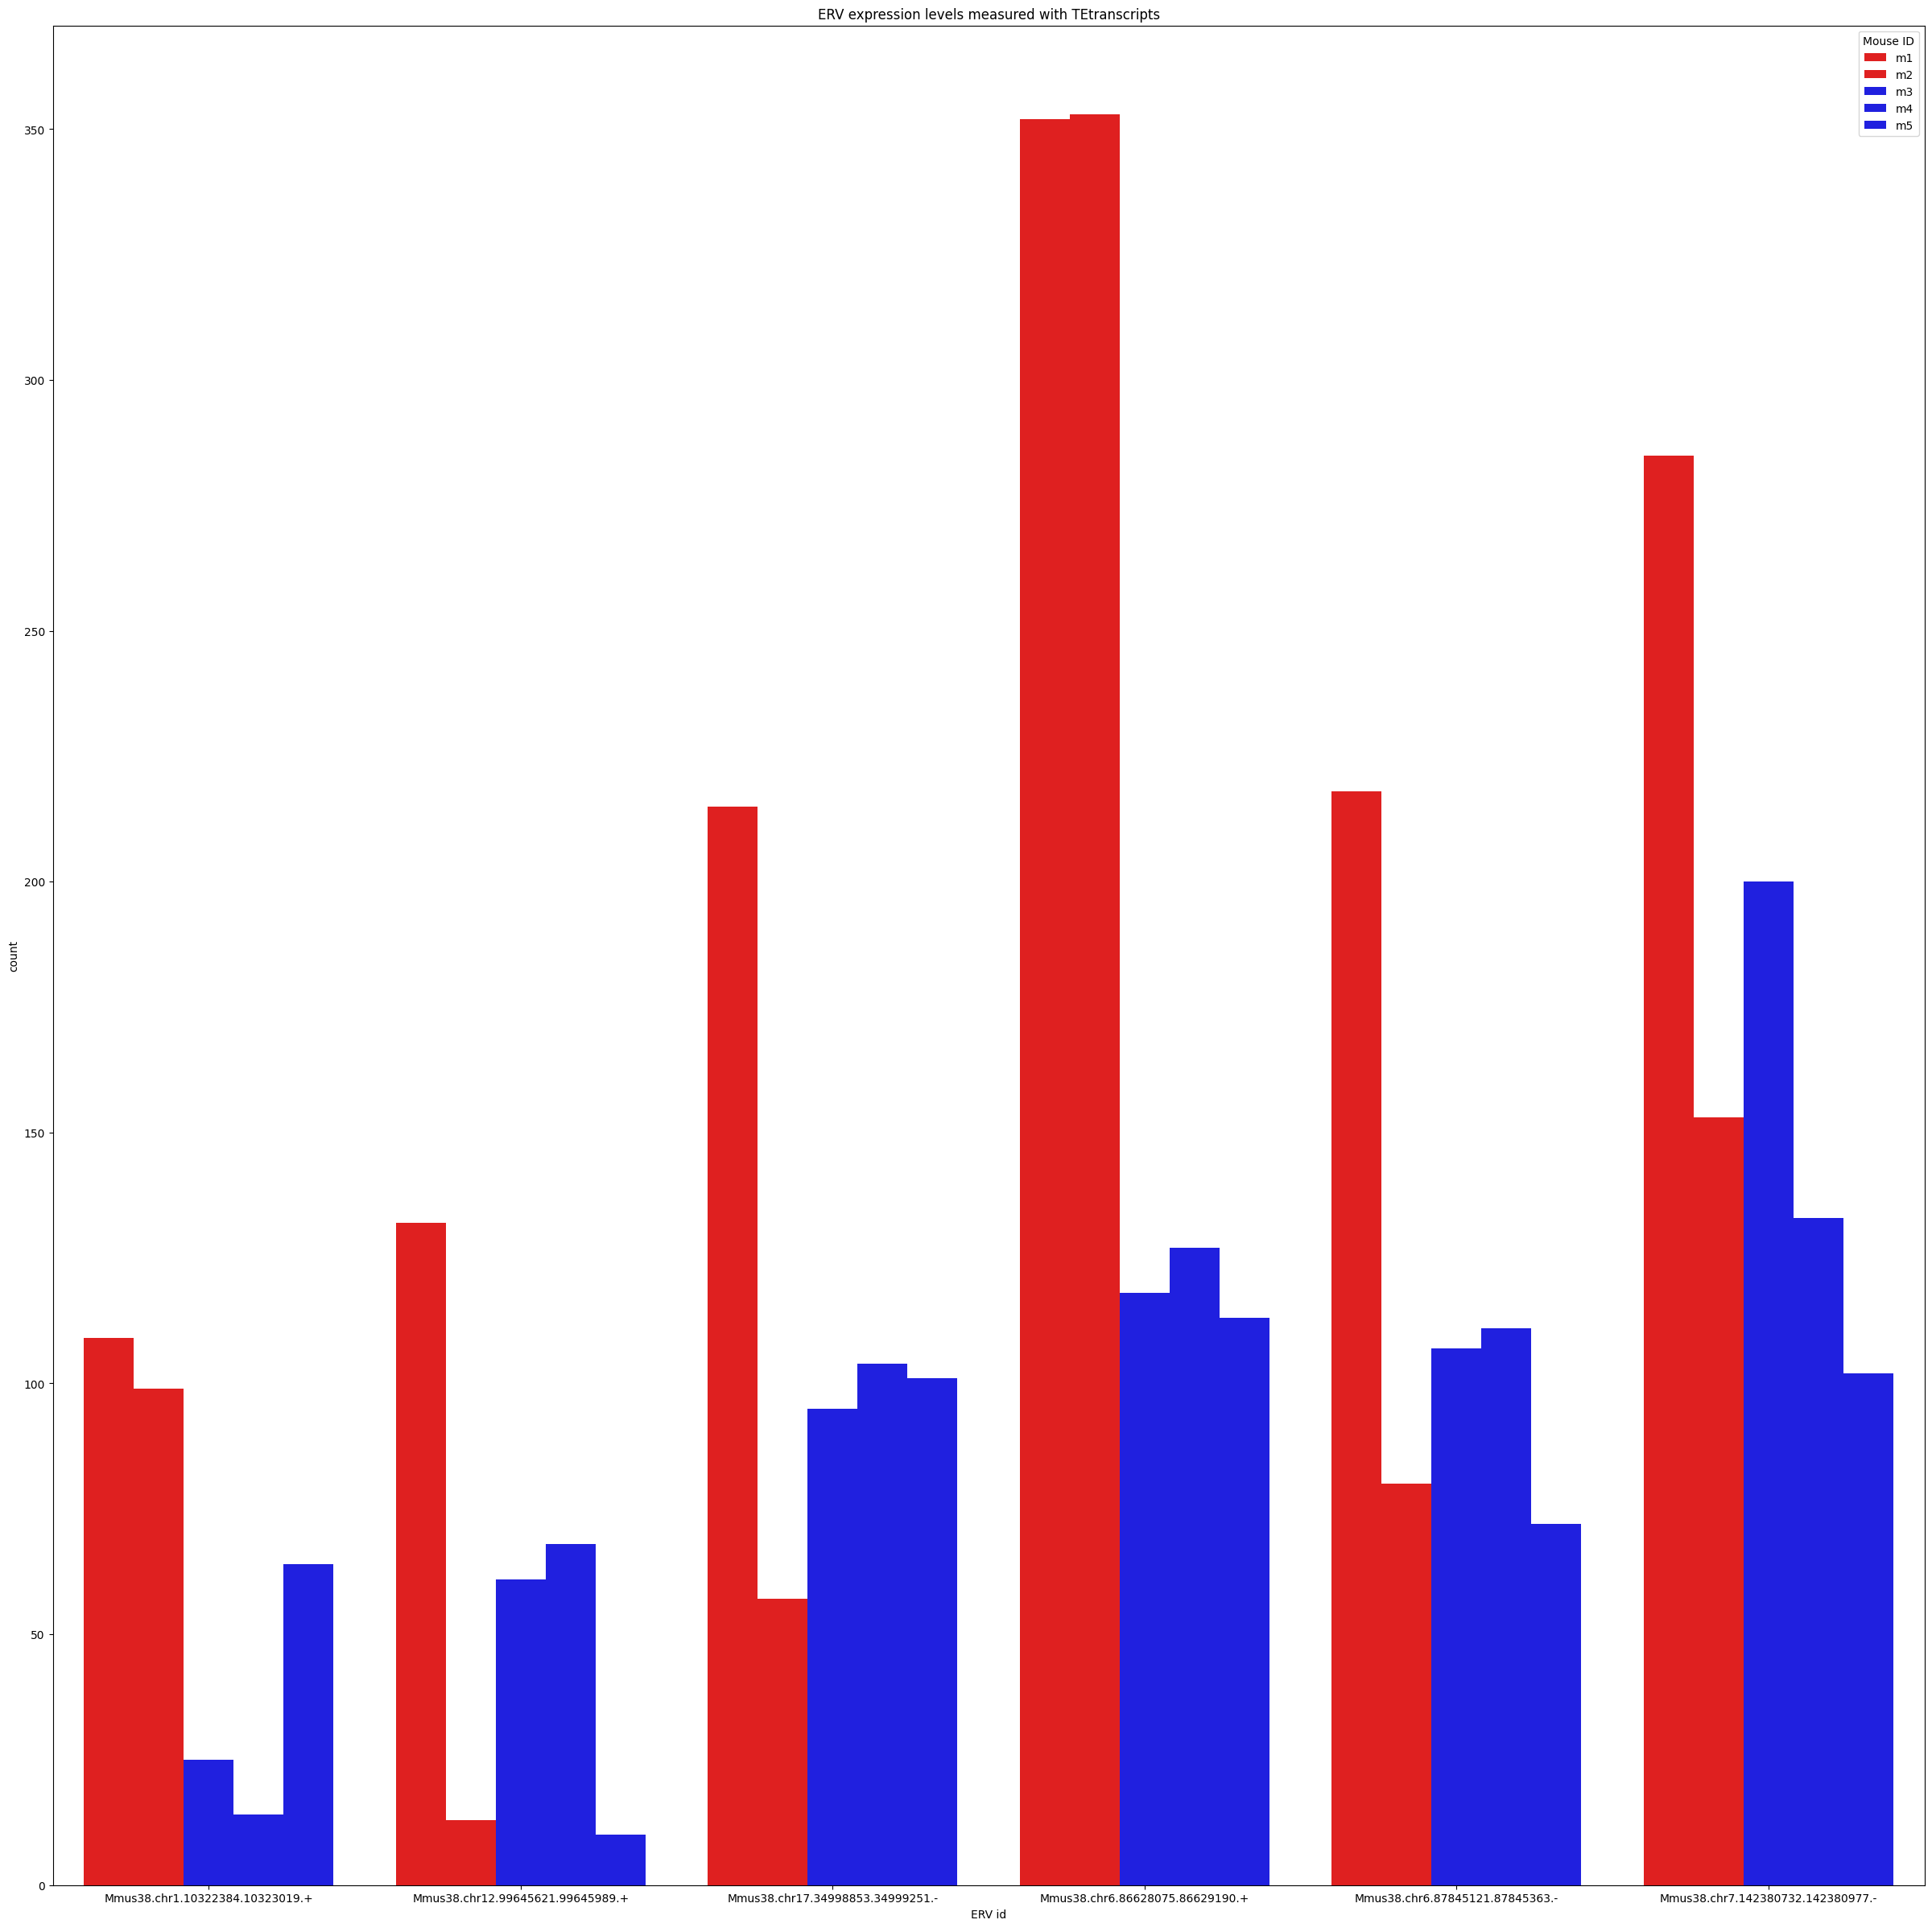

In [40]:
visualise_barplot(reshaped_filtered , 'full_TET2.jpg')

In [44]:
filtered = remove_lowly_expressed(expr_ERV, 20)
print(filtered.info())

#reshaped_filtered = reshape_dataframe(filtered)
#print(reshaped_filtered.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   gene_id  6 non-null      object
 1   m1       6 non-null      int64 
 2   m2       6 non-null      int64 
 3   m3       6 non-null      int64 
 4   m4       6 non-null      int64 
 5   m5       6 non-null      int64 
dtypes: int64(5), object(1)
memory usage: 416.0+ bytes
None


In [45]:
df1 = filtered.iloc[:20]
df2 = filtered.iloc[20:40]
df3 = filtered.iloc[40:60]
df4 = filtered.iloc[60:]


In [46]:
df1 = reshape_dataframe(df1)
df2 = reshape_dataframe(df2)
df3 = reshape_dataframe(df3)
df4 = reshape_dataframe(df4)

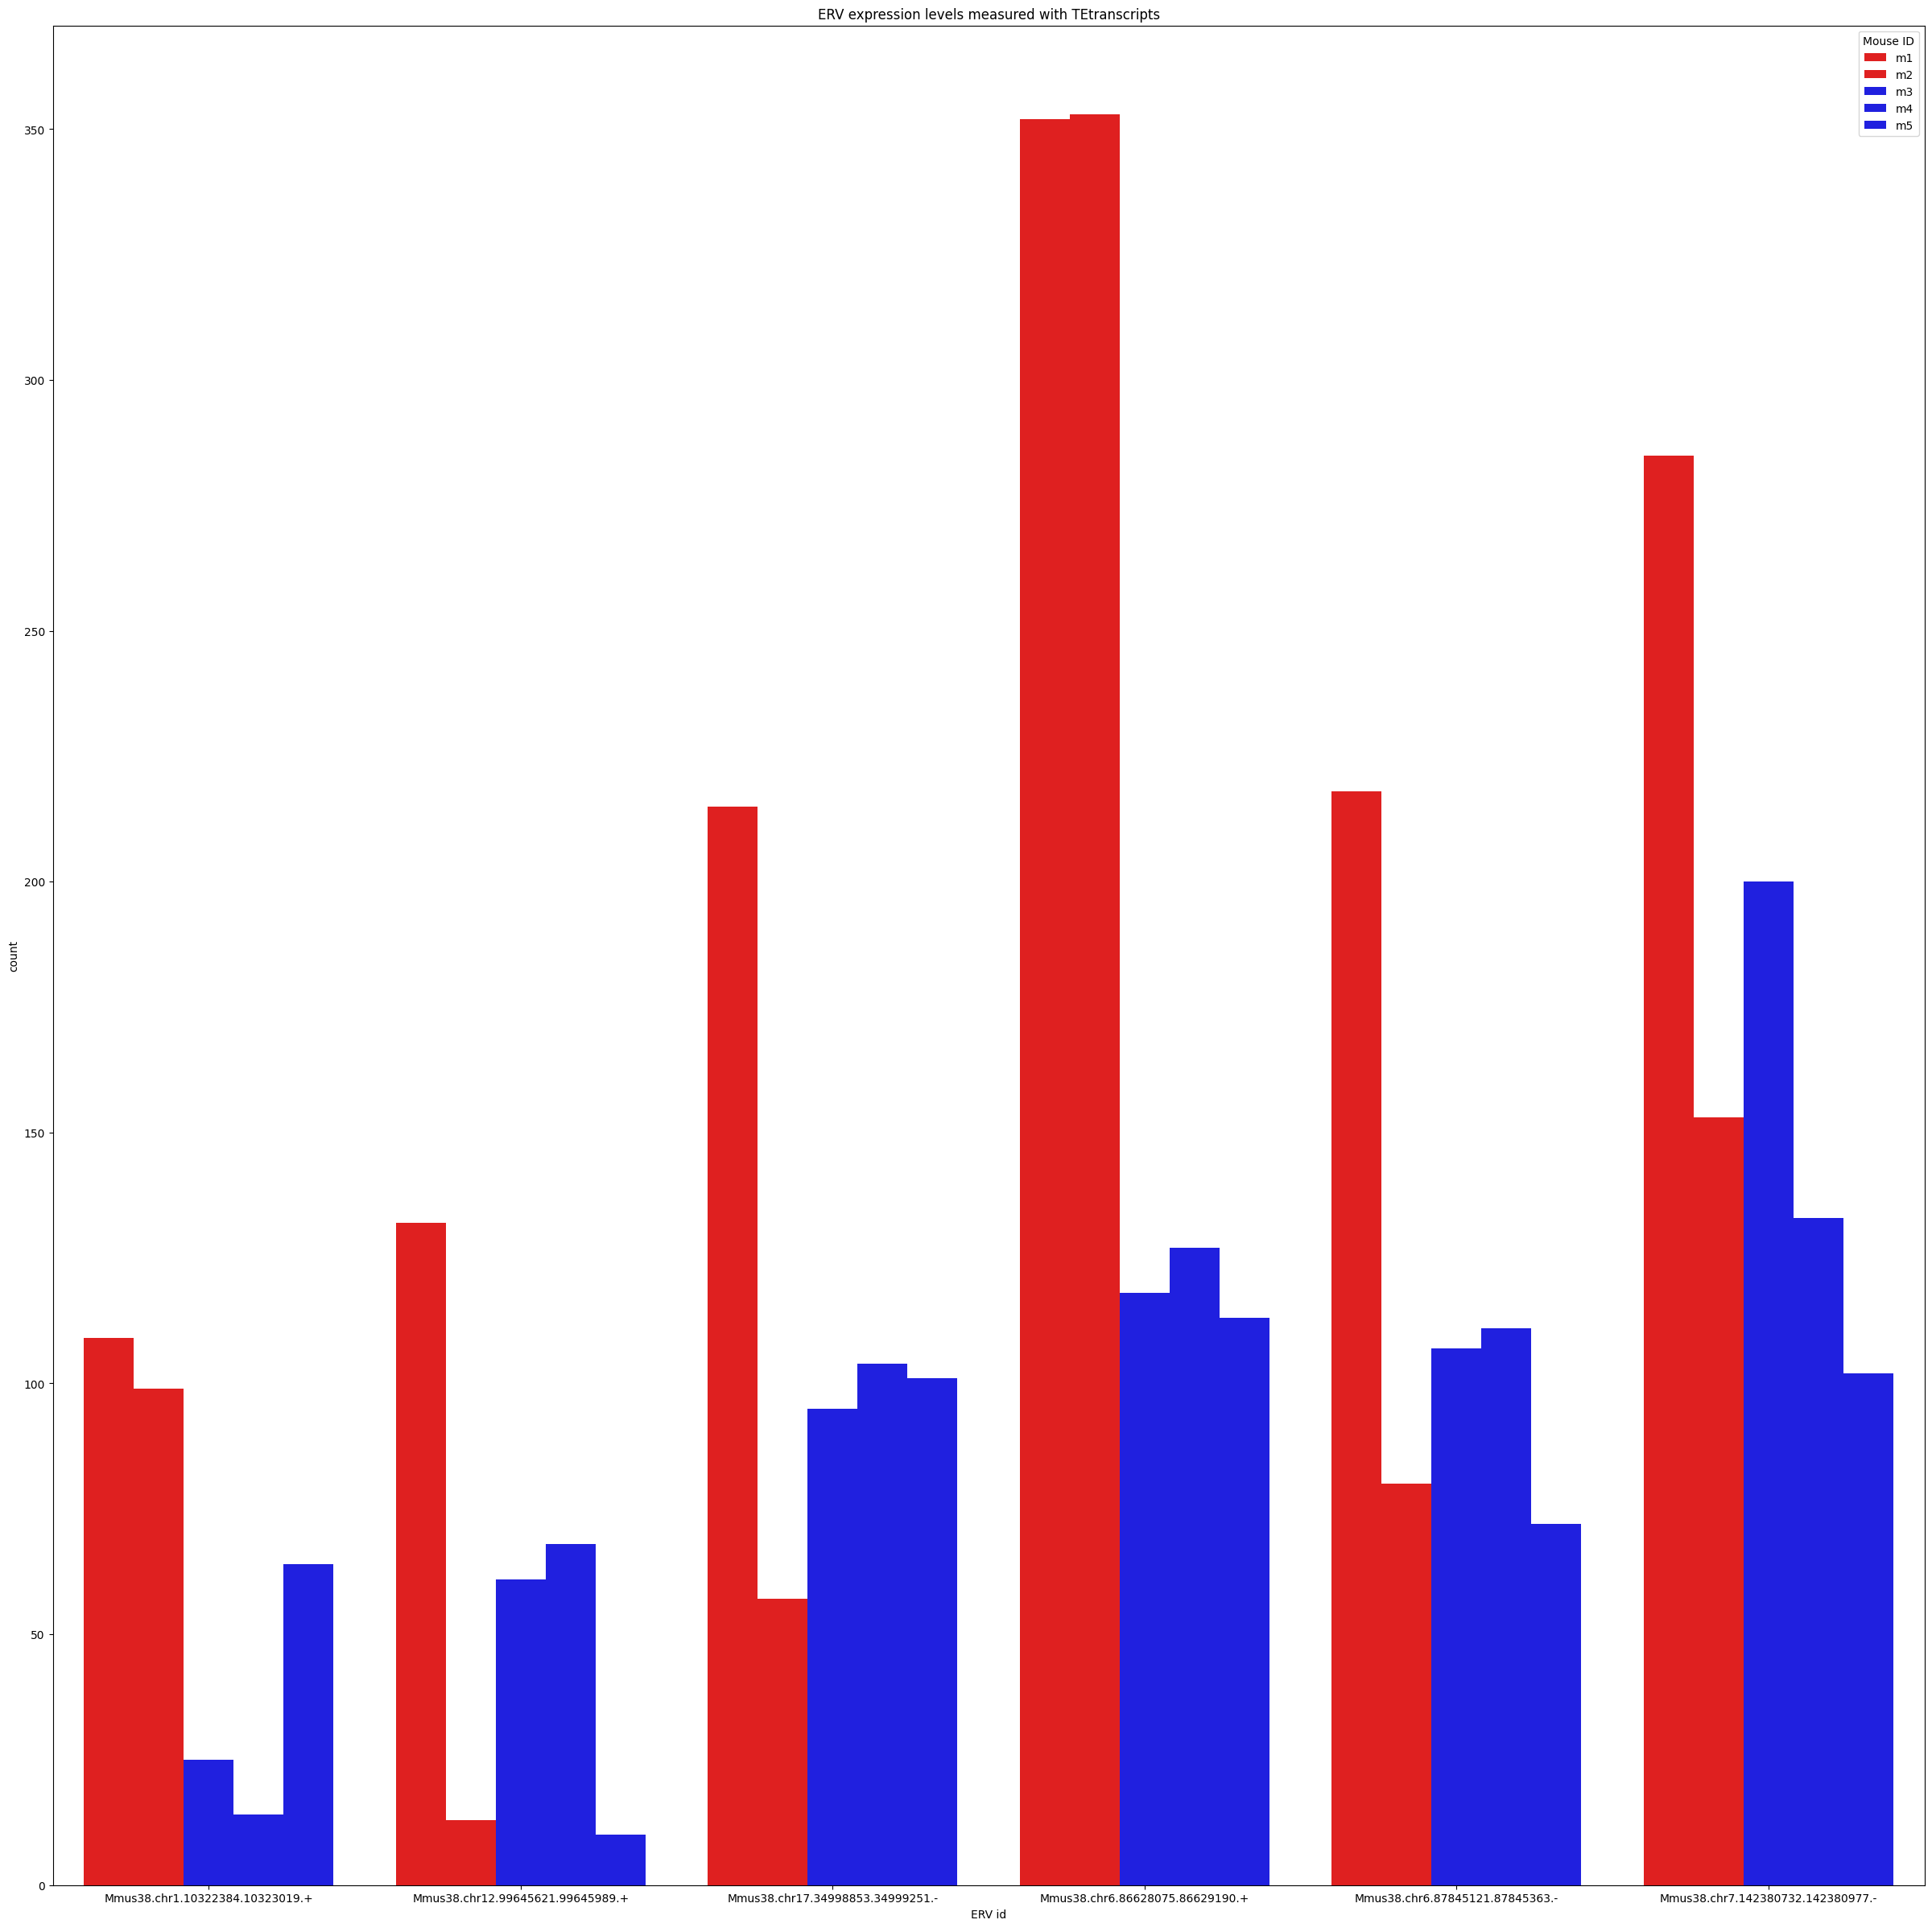

In [47]:
visualise_barplot(df1, 'df1_TET2.jpg')

In [ ]:
#visualise_barplot(df3, 'df2_TET2.jpg')

In [50]:
#visualise_barplot(df3, 'df3_TET2.jpg')

In [51]:
#visualise_barplot(df4, 'df4_TET2.jpg')

DEseq results analysis

OVEREXPRESSED OR UNDEREXPRESSED? (current p-val threshold 0.05)

In [54]:
sigdiff_TET2 = pd.read_csv('/work/iku/exp1019-cancer-epigenetics-and-ervs/01_BS_and_ERV/results/04_TEtranscripts/TET2/TET2_sigdiff_gene_TE.txt', sep = '\t')

In [60]:
print(sigdiff_TET2.head())
print(len(sigdiff_TET2))

                      baseMean  log2FoldChange     lfcSE      stat  \
ENSMUSG00000000823  245.205348       -1.055561  0.298706 -3.533779   
ENSMUSG00000001865  838.785836       -2.864991  0.607376 -4.716997   
ENSMUSG00000001986  573.850866       -2.141422  0.507248 -4.221643   
ENSMUSG00000002565  455.154383       -2.222979  0.503654 -4.413707   
ENSMUSG00000007480  111.961850       -2.545473  0.499293 -5.098149   

                          pvalue      padj  
ENSMUSG00000000823  4.096633e-04  0.034736  
ENSMUSG00000001865  2.393512e-06  0.000563  
ENSMUSG00000001986  2.425277e-05  0.003763  
ENSMUSG00000002565  1.016153e-05  0.001785  
ENSMUSG00000007480  3.429899e-07  0.000111  
200


In [57]:
sigdiff_TET2_ERV = sigdiff_TET2.loc[sigdiff_TET2.index.str.startswith('Mmus38')]


In [58]:
print(sigdiff_TET2_ERV)
print(len(sigdiff_TET2_ERV)) #11
nr_of_expressed_genes = 2819 #assuming any abundance is good 


Empty DataFrame
Columns: [baseMean, log2FoldChange, lfcSE, stat, pvalue, padj]
Index: []
0


In [31]:
TET2_dif_expr_ERVs = sigdiff_TET2_ERV.index.tolist()

In [32]:
print(TET2_dif_expr_ERVs)

['Mmus38.chr15.9777831.9778091.+', 'Mmus38.chr17.18566495.18567163.+', 'Mmus38.chr17.18567139.18567867.+', 'Mmus38.chr17.18568818.18569141.+', 'Mmus38.chr17.18622859.18623134.+', 'Mmus38.chr4.117192595.117194406.+', 'Mmus38.chr4.117195149.117197833.+', 'Mmus38.chr8.121835414.121838953.+', 'Mmus38.chr8.121838853.121839896.+', 'Mmus38.chr8.121839776.121840789.+', 'Mmus38.chr8.82749823.82750206.-']


In [47]:
TEcounts_TET2_dif_expr_ERVs = ['Mmus38.chr1.26474418.26475755.-', 'Mmus38.chr10.71819059.71822958.-', 'Mmus38.chr12.43659073.43661217.+',
             'Mmus38.chr12.49126699.49129311.+', 'Mmus38.chr12.96000997.96004887.-', 'Mmus38.chr17.41688925.41690115.-',
             'Mmus38.chr17.62397216.62399306.-', 'Mmus38.chr19.48965554.48966675.+', 'Mmus38.chr19.8321592.8321936.-',
             'Mmus38.chr3.49359831.49360262.+', 'Mmus38.chr7.26192088.26192735.-', 'Mmus38.chr8.97622899.97624665.+']

In [48]:
def compare_ERV_sets(l1, l2):
    set1 = set(l1)
    set2 = set(l2)
    
    only_in_l1 = set1 - set2
    only_in_l2 = set2 - set1
    shared = set1 & set2
    
    print('ERVs only in l1:', only_in_l1, '\n')
    print('ERVs only in l2:', only_in_l2, '\n')
    print('ERVs shared:', shared, '\n')


In [49]:
compare_ERV_sets(TET2_dif_expr_ERVs, TEcounts_TET2_dif_expr_ERVs)

ERVs only in l1: {'Mmus38.chr4.117195149.117197833.+', 'Mmus38.chr17.18568818.18569141.+', 'Mmus38.chr8.121835414.121838953.+', 'Mmus38.chr17.18567139.18567867.+', 'Mmus38.chr17.18566495.18567163.+', 'Mmus38.chr15.9777831.9778091.+', 'Mmus38.chr4.117192595.117194406.+', 'Mmus38.chr8.121838853.121839896.+', 'Mmus38.chr17.18622859.18623134.+', 'Mmus38.chr8.82749823.82750206.-', 'Mmus38.chr8.121839776.121840789.+'} 

ERVs only in l2: {'Mmus38.chr12.49126699.49129311.+', 'Mmus38.chr19.8321592.8321936.-', 'Mmus38.chr12.96000997.96004887.-', 'Mmus38.chr7.26192088.26192735.-', 'Mmus38.chr3.49359831.49360262.+', 'Mmus38.chr1.26474418.26475755.-', 'Mmus38.chr17.41688925.41690115.-', 'Mmus38.chr12.43659073.43661217.+', 'Mmus38.chr17.62397216.62399306.-', 'Mmus38.chr8.97622899.97624665.+', 'Mmus38.chr10.71819059.71822958.-', 'Mmus38.chr19.48965554.48966675.+'} 

ERVs shared: set() 



In [50]:
sigdiff_NZM = pd.read_csv('/work/iku/exp1019-cancer-epigenetics-and-ervs/01_BS_and_ERV/results/04_TEtranscripts/NZM/1/NZM_sigdiff_gene_TE.txt', sep = '\t')

In [51]:
sigdiff_NZM_ERV = sigdiff_NZM.loc[sigdiff_NZM.index.str.startswith('Hsap38')]

In [52]:
print(sigdiff_NZM_ERV)
print(len(sigdiff_NZM_ERV))

                                  baseMean  log2FoldChange     lfcSE  \
Hsap38.chr19.27638542.27640647.-  6.551632       -6.363206  1.834642   
Hsap38.chr19.27640343.27641698.-  6.442515       -6.338902  1.837468   

                                      stat    pvalue      padj  
Hsap38.chr19.27638542.27640647.- -3.468365  0.000524  0.047465  
Hsap38.chr19.27640343.27641698.- -3.449803  0.000561  0.049599  
2


METHYLATION CALL

In [53]:
columns = ['chromosome', 'position', 'strand', 'count_methylated', 'count_unmethylated', 'C-context', 'trinucleotide_context']
cyt_rep  = pd.read_csv('/work/iku/exp1019-cancer-epigenetics-and-ervs/01_BS_and_ERV/results/bismark/methylation_call_raw/DNMT3A/1_Bisulfite-Seq_SRR4238585/cytosine_report.txt.CpG_report.txt', sep = '\t', dtype=str, names = columns)
print(cyt_rep.head())

  chromosome position strand count_methylated count_unmethylated C-context  \
0         17  3000204      +                0                  0        CG   
1         17  3000205      -                0                  0        CG   
2         17  3000350      +                0                  0        CG   
3         17  3000351      -                0                  0        CG   
4         17  3000417      +                0                  0        CG   

  trinucleotide_context  
0                   CGT  
1                   CGA  
2                   CGA  
3                   CGC  
4                   CGA  


In [54]:
columns = ['chromosome', 'start_position', 'end_position', 'methylation_percentage', 'count_methylated', 'count_unmethylated']
cov = pd.read_csv('/work/iku/exp1019-cancer-epigenetics-and-ervs/01_BS_and_ERV/results/bismark/methylation_call_raw/DNMT3A/1_Bisulfite-Seq_SRR4238585/SRR4238585.bismark.cov.gz', compression = 'gzip', sep = '\t', dtype = str, names = columns)
print(cov.head())

  chromosome start_position end_position methylation_percentage  \
0         17        3002459      3002459                    100   
1         17        3002721      3002721                    100   
2         17        3003123      3003123                      0   
3         17        3003661      3003661                      0   
4         17        3027756      3027756                    100   

  count_methylated count_unmethylated  
0                1                  0  
1                1                  0  
2                0                  1  
3                0                  1  
4                1                  0  


In [55]:
columns = ['chromosome', 'start_position', 'end_position', 'methylation_percentage']
bedGraph = pd.read_csv('/work/iku/exp1019-cancer-epigenetics-and-ervs/01_BS_and_ERV/results/bismark/methylation_call_raw/DNMT3A/1_Bisulfite-Seq_SRR4238585/SRR4238585.bedGraph.gz', names=columns, sep='\t', dtype = str)

In [56]:
print(bedGraph.head())

            chromosome start_position end_position methylation_percentage
0  track type=bedGraph            NaN          NaN                    NaN
1                   17        3002458      3002459                    100
2                   17        3002720      3002721                    100
3                   17        3003122      3003123                      0
4                   17        3003660      3003661                      0
